<a href="https://colab.research.google.com/github/regina-fonseca-avila/data_science/blob/main/cohort/cohort_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Cohort Analysis Heatmap

* **Rows** - First activity - **Example:** month of acquisition

* **Columns** - Time since first activity - **Example:** months since acquisition

# Data

**UCI machine learning repository**

Online Retail Data Set

More information [here](https://archive.ics.uci.edu/ml/datasets/online+retail#).


## Read data

In [2]:

file_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
            
online = pd.read_excel(file_path)

In [3]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
online.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# cleaning dataset
online = online[online.UnitPrice > 0]
online = online[online.Quantity > 0]
online = online[~online.CustomerID.isna()]

# Assign monthly acquisition cohort and monthly invoice
We will now create monthly cohorts based on the month each customer has made their first transaction.



In [6]:
# Create InvoiceMonth column
online['InvoiceMonth'] = online['InvoiceDate'].dt.to_period('M')

# Group by CustomerID and select the InvoiceMonth value
grouping = online.groupby('CustomerID')['InvoiceMonth']

# Assign a minimum invoiceMonth value to the dataset
online['CohortMonth'] = grouping.transform('min')

# View the top 5 rows
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12


Now each customer belongs to a monthly acquisition cohort that you can use for further analysis!

# CohortIndex
We will calculate the difference between the Invoice and Cohort dates in months.

In [7]:
online['CohortIndex'] = (online.InvoiceMonth - online.CohortMonth)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12,<0 * MonthEnds>
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,<0 * MonthEnds>
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12,<0 * MonthEnds>
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,<0 * MonthEnds>
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,<0 * MonthEnds>


In [8]:
# extract the integer part
online['CohortIndex'] = online['CohortIndex'].apply(lambda x: x.n +1)

In [9]:
online.dtypes

InvoiceNo               object
StockCode               object
Description             object
Quantity                 int64
InvoiceDate     datetime64[ns]
UnitPrice              float64
CustomerID             float64
Country                 object
InvoiceMonth         period[M]
CohortMonth          period[M]
CohortIndex              int64
dtype: object

## Count monthly active customers from each cohort

In [10]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Customer retention
Customer retention is a very useful metric to understand how many of all the customers are still active. 

**Customer retention** = Percentage of active customers out of total customers

In [11]:
# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Review the retention table
retention.round(3)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366,0.323,0.384,0.363,0.398,0.363,0.349,0.354,0.395,0.374,0.503,0.266
2011-01,1.0,0.221,0.266,0.230,0.321,0.288,0.247,0.242,0.300,0.326,0.365,0.118,NaN
2011-02,1.0,0.187,0.187,0.284,0.271,0.247,0.253,0.279,0.247,0.305,0.068,NaN,NaN
2011-03,1.0,0.150,0.252,0.199,0.223,0.168,0.268,0.230,0.279,0.086,NaN,NaN,NaN
2011-04,1.0,0.213,0.203,0.210,0.197,0.227,0.217,0.260,0.073,NaN,NaN,NaN,NaN
2011-05,1.0,0.190,0.173,0.173,0.208,0.232,0.264,0.095,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.174,0.157,0.264,0.231,0.335,0.095,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.181,0.207,0.223,0.271,0.112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207,0.249,0.243,0.124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we have built the retention metrics table for monthly cohorts.

# Average quantity

In [12]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the Quantity column
cohort_data = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')

# the Average quantity table
average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,11.9,15.6,15.6,15.8,13.5,14.8,16.0,15.5,18.1,17.6,18.9,13.4,15.3
2011-01,17.2,13.3,12.6,15.1,12.8,15.3,14.9,14.8,11.6,10.5,9.4,10.0,NaN
2011-02,11.1,13.5,19.0,12.0,12.3,12.3,13.5,13.3,10.9,12.3,13.4,NaN,NaN
2011-03,9.9,11.7,13.3,10.1,14.3,13.0,13.4,13.7,11.2,9.5,NaN,NaN,NaN
2011-04,10.0,10.4,9.8,11.8,11.8,8.6,9.9,9.5,7.4,NaN,NaN,NaN,NaN
2011-05,11.3,9.6,14.1,12.8,11.1,8.7,10.6,109.9,NaN,NaN,NaN,NaN,NaN
2011-06,10.6,14.5,10.8,13.5,10.6,9.8,9.4,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,9.8,13.8,7.3,8.1,6.1,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,10.0,6.2,5.4,6.2,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Average price
When we calculatethe average price metric we can analyze if there are any differences in shopping patterns across time and across cohorts.


In [13]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
average_price.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,3.1,3.1,3.0,3.2,2.9,3.8,3.0,2.8,3.0,2.8,3.2,2.8,2.7
2011-01,3.2,3.5,3.0,5.7,3.1,3.1,2.9,2.7,2.6,4.2,2.8,2.5,NaN
2011-02,3.3,3.8,3.8,3.1,2.9,2.8,2.8,3.2,2.9,2.9,3.2,NaN,NaN
2011-03,3.3,4.2,3.4,3.2,3.0,2.7,2.8,2.8,2.7,2.4,NaN,NaN,NaN
2011-04,3.4,3.7,3.3,2.7,2.9,2.9,2.9,2.8,2.6,NaN,NaN,NaN,NaN
2011-05,3.9,3.0,2.6,3.0,2.7,2.5,2.6,2.5,NaN,NaN,NaN,NaN,NaN
2011-06,3.5,2.8,3.3,2.8,2.6,3.0,2.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,3.0,3.3,2.7,2.7,2.4,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,3.0,4.6,4.9,5.8,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Build the heatmap

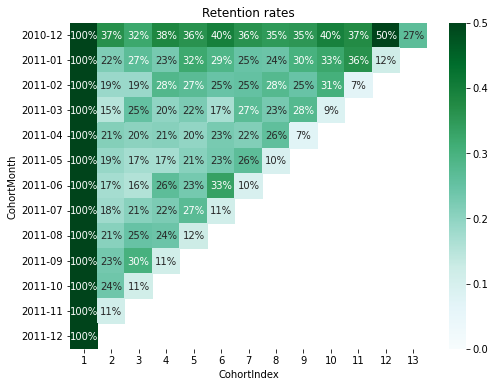

In [14]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Retention rates')

# Create the heatmap
sns.heatmap(data = retention,
            annot=True,
            fmt = '.0%',
            vmin = 0.0,
            vmax = 0.5,
            cmap='BuGn')

# vmin, vmax = garante que outliers não impactem a visualização

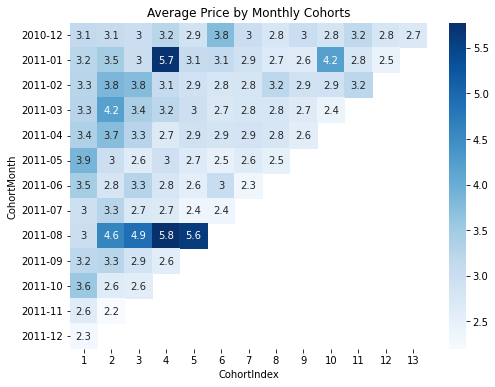

In [15]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Price by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_price, annot=True, cmap='Blues')
plt.show()

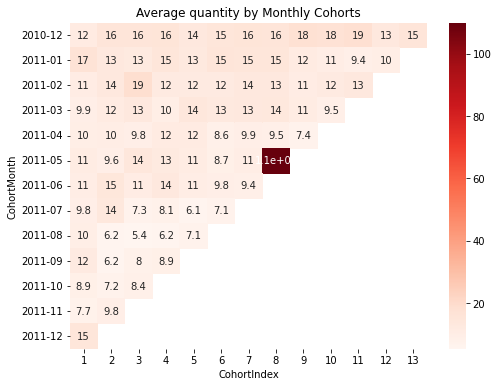

In [16]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average quantity by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_quantity, annot=True, cmap='Reds')


- There is a outlier in `CohortMonth` = 2011-05 and `CohortIndex` = 8

# Show Cohort Size

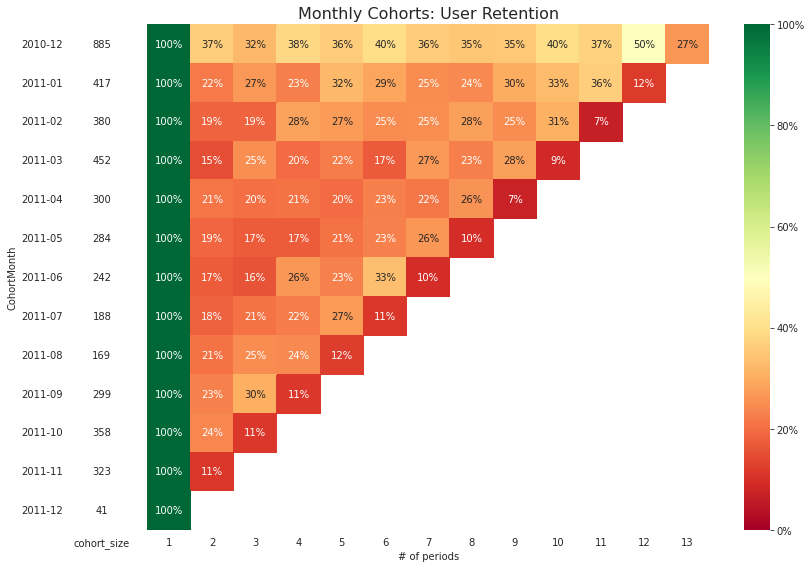

In [17]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    

    fmt = lambda x,pos: '{:.0%}'.format(x)
    from matplotlib.ticker import FuncFormatter

    # retention matrix
    sns.heatmap(retention, 
                mask=retention.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1],
                vmin =0,
                vmax = 1,
                cbar_kws={'format': FuncFormatter(fmt)})
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_sizes).rename(columns={1: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False,
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])


    fig.tight_layout()

# Different cmap

- cmap = 'RdYlBu'

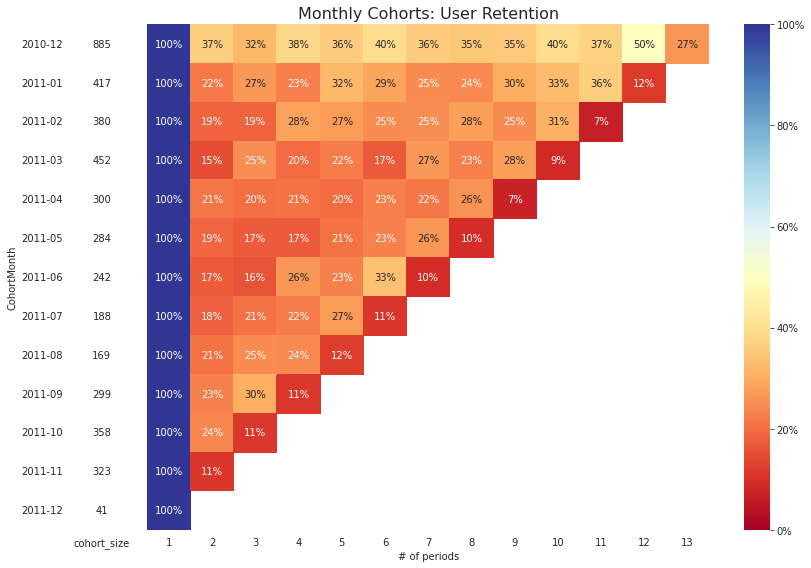

In [18]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    

    fmt = lambda x,pos: '{:.0%}'.format(x)
    from matplotlib.ticker import FuncFormatter

    # retention matrix
    sns.heatmap(retention, 
                mask=retention.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlBu', 
                ax=ax[1],
                vmin =0,
                vmax = 1,
                cbar_kws={'format': FuncFormatter(fmt)})
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_sizes).rename(columns={1: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False,
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])


    fig.tight_layout()

# References:
1. https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

2. https://blaizh.medium.com/understanding-customer-retention-rates-with-cohort-analysis-using-python-and-seaborn-5da6ea015935

3. https://github.com/mwaskom/seaborn/issues/917 (CharlesGaydon commented on Oct 16, 2019)

4. https://app.datacamp.com/learn/courses/customer-segmentation-in-python